# Analysis of collaboration and migration trends in Israel and the impact of events

Displaying data on articles that are Israel's collaboration with other countries

In [38]:
import pandas as pd
df_israel = pd.read_csv("../data/collaboration/israel_publications_per_year.csv", engine="python", sep=None)
df_israel.tail(10)

,year,total_in_israel,collab_in_israel,collab_percent
116,2015,22648,10561,46.63
117,2016,24323,11344,46.64
118,2017,25072,11785,47.00
119,2018,26415,12898,48.83
120,2019,28081,14067,50.09
121,2020,31323,15956,50.94
122,2021,32820,16650,50.73
123,2022,29292,14635,49.96
124,2023,24042,12724,52.92
125,2024,86,48,55.81


Showing the size of Israel's population each year (for normalization purposes)

In [39]:
import pandas as pd
df_population = pd.read_csv("../data/wbdata/israel_population_1948_2024.csv", engine="python", sep=None)
df_population.tail(10)

,year,population
67,2015,8462000
68,2016,8522000
69,2017,8630000
70,2018,8972000
71,2019,9092000
72,2020,9291000
73,2021,9998000
74,2022,9656000
75,2023,9795000
76,2024,9842000


Calculation of migration balance for each year

In [ ]:
import pandas as pd

df_b = pd.read_csv("../data/moving_between_countries/country_year_metrics.csv")

# Work copy and normalize year type
df_bal = df_b.copy()
df_bal["year"] = pd.to_numeric(df_bal["year"], errors="coerce").astype("Int64")

# Calculate total left and arrived
df_bal["left_total"] = df_bal["left_permanent"].fillna(0) + df_bal["left_temporary"].fillna(0)
arrived_sum = df_bal["arrived_permanent"].fillna(0) + df_bal["arrived_temporary"].fillna(0)
df_bal["arrived_total_final"] = df_bal["arrived_total"].fillna(arrived_sum)

# Balance by move type
df_bal["balance_permanent"] = df_bal["arrived_permanent"].fillna(0) - df_bal["left_permanent"].fillna(0)
df_bal["balance_temporary"] = df_bal["arrived_temporary"].fillna(0) - df_bal["left_temporary"].fillna(0)
df_bal["balance_overall"]   = df_bal["arrived_total_final"] - df_bal["left_total"]

# Filter for Israel between 1948 and 2024
balance = (
    df_bal[(df_bal["country"] == "Israel") & (df_bal["year"].between(1948, 2024))]
    .loc[:, ["year", "country", "balance_permanent", "balance_temporary", "balance_overall"]]
    .sort_values(["year"])
    .reset_index(drop=True)
)

balance


,year,country,balance_permanent,balance_temporary,balance_overall
0,1948,Israel,2,2,4
1,1949,Israel,-10,8,-2
2,1950,Israel,1,6,7
3,1951,Israel,-3,4,1
4,1952,Israel,5,4,9
...,...,...,...,...,...
72,2020,Israel,-1155,1224,69
73,2021,Israel,-1205,1541,336
74,2022,Israel,-1351,1052,-299
75,2023,Israel,-154,114,-40


Calculating a normalized migration balance

In [ ]:
# Merge by year
balance_norm = pd.merge(
    balance,
    df_population,
    on="year",
    how="left"
)

# Calculate normalized values (per million inhabitants)
balance_norm["balance_permanent_per_million"] = balance_norm["balance_permanent"] / (balance_norm["population"] / 1_000_000)
balance_norm["balance_temporary_per_million"] = balance_norm["balance_temporary"] / (balance_norm["population"] / 1_000_000)
balance_norm["balance_overall_per_million"]   = balance_norm["balance_overall"]   / (balance_norm["population"] / 1_000_000)

# Keep relevant columns
balance_norm = balance_norm[
    ["year", "country", "population",
     "balance_permanent", "balance_temporary", "balance_overall",
     "balance_permanent_per_million", "balance_temporary_per_million", "balance_overall_per_million"]
]

balance_norm


,year,country,population,balance_permanent,balance_temporary,balance_overall,balance_permanent_per_million,balance_temporary_per_million,balance_overall_per_million
0,1948,Israel,806000,2,2,4,2.481390,2.481390,4.962779
1,1949,Israel,1174000,-10,8,-2,-8.517888,6.814310,-1.703578
2,1950,Israel,1370000,1,6,7,0.729927,4.379562,5.109489
3,1951,Israel,1578000,-3,4,1,-1.901141,2.534854,0.633714
4,1952,Israel,1630000,5,4,9,3.067485,2.453988,5.521472
...,...,...,...,...,...,...,...,...,...
72,2020,Israel,9291000,-1155,1224,69,-124.313852,131.740394,7.426542
73,2021,Israel,9998000,-1205,1541,336,-120.524105,154.130826,33.606721
74,2022,Israel,9656000,-1351,1052,-299,-139.913007,108.947804,-30.965203
75,2023,Israel,9795000,-154,114,-40,-15.722307,11.638591,-4.083716


## Creating a graph of collaboration and migration trends in Israel and the impact of events

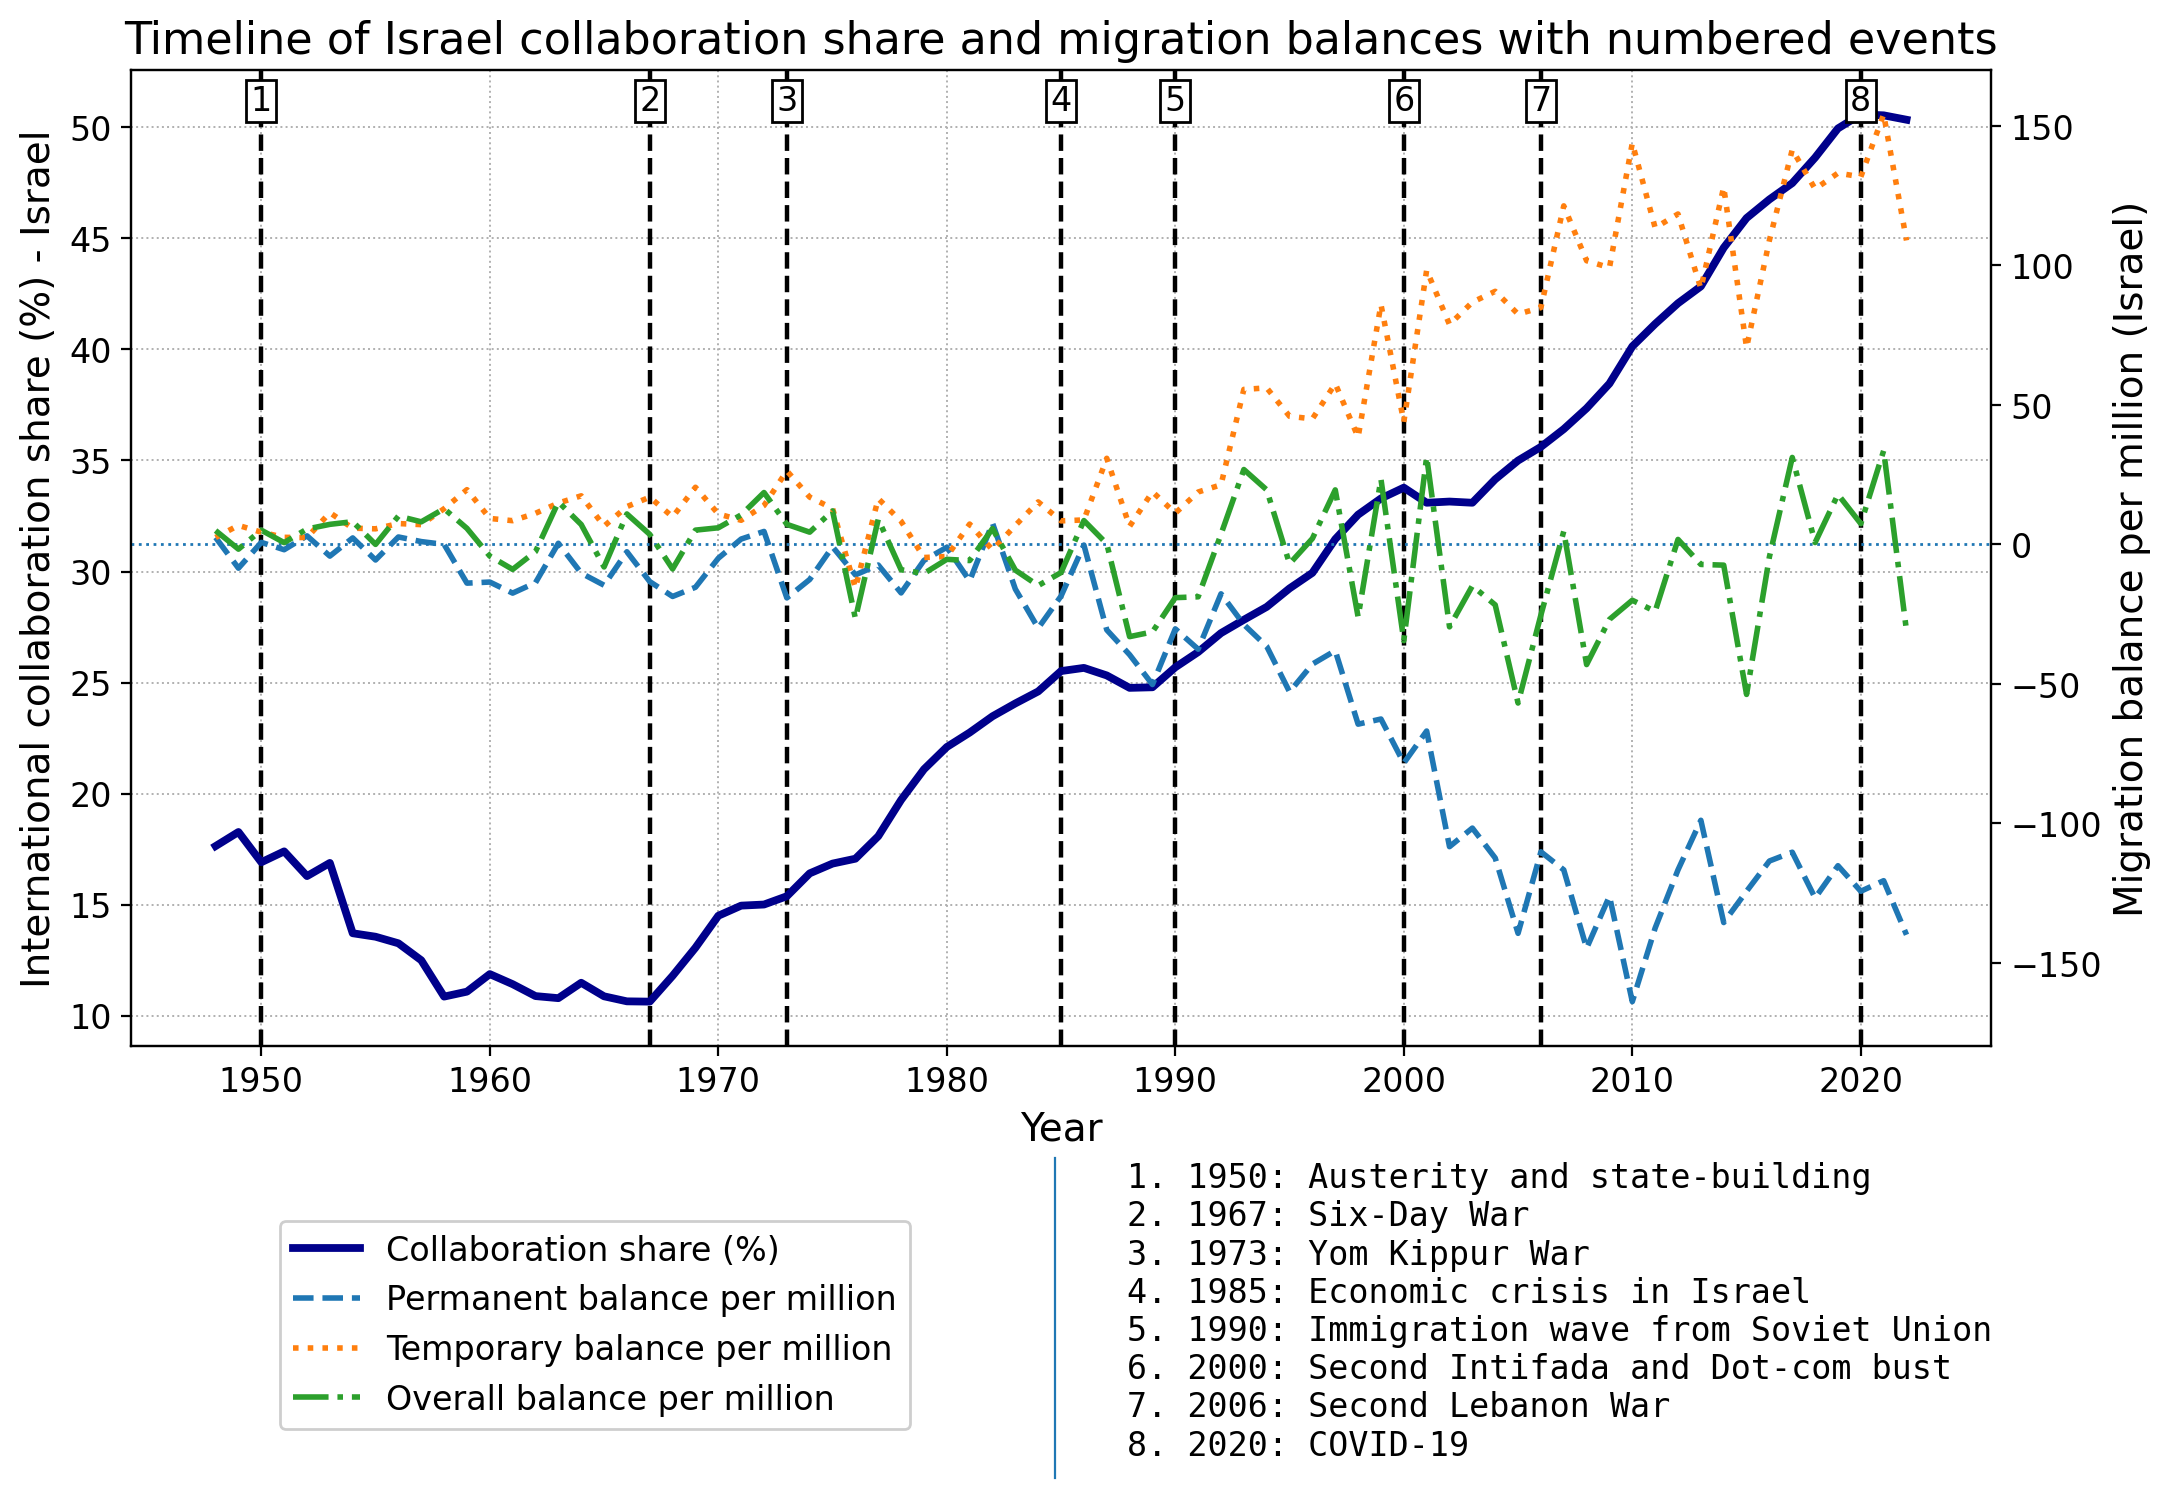

'timeline_israel_collab_migration.png'

In [79]:
# Updated timeline code: plots Israel collaboration share
# and 3 types of migration balance per million, with numbered events centered on lines.
# Legend sits at bottom-left. Event list sits next to it at bottom-right on the same row.

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import ceil
from pathlib import Path

# -------- 1) Load Israel collaboration data --------
csv_path = Path("../data/collaboration/israel_publications_per_year.csv")

df_israel = pd.read_csv(csv_path, engine="python", sep=None)
df_israel.columns = [c.strip().lower() for c in df_israel.columns]

expected = {"year", "total_in_israel", "collab_in_israel", "collab_percent"}
missing = expected - set(df_israel.columns)
if missing:
    raise ValueError(f"Missing expected columns in CSV: {missing}")

df_israel = df_israel.copy()
df_israel["year"] = pd.to_numeric(df_israel["year"], errors="coerce")
df_israel["collab_percent"] = pd.to_numeric(df_israel["collab_percent"], errors="coerce")
df_israel = df_israel.dropna(subset=["year", "collab_percent"])
df_israel = df_israel[(df_israel["year"] >= 1948) & (df_israel["year"] <= 2022)]
df_israel = df_israel[(df_israel["collab_percent"] >= 0) & (df_israel["collab_percent"] <= 100)]
df_israel = df_israel.sort_values("year")

# Optional smoothing
df_israel["collab_percent_smoothed"] = (
    df_israel["collab_percent"].rolling(window=3, min_periods=1, center=True).mean()
)

# -------- 2) Merge with migration balance (from balance_norm) --------
df_merge = pd.merge(
    df_israel[["year", "collab_percent_smoothed"]],
    balance_norm[[
        "year",
        "balance_permanent_per_million",
        "balance_temporary_per_million",
        "balance_overall_per_million"
    ]],
    on="year",
    how="inner"
)

df = pd.DataFrame({
    "year": df_merge["year"],
    "israel_collab_share_pct": df_merge["collab_percent_smoothed"],
    "balance_permanent_per_million": df_merge["balance_permanent_per_million"],
    "balance_temporary_per_million": df_merge["balance_temporary_per_million"],
    "balance_overall_per_million": df_merge["balance_overall_per_million"]
})

# -------- 3) Events to annotate --------
events = [
    (1950, "Austerity and state-building"),
    (1967, "Six-Day War"),
    (1973, "Yom Kippur War"),
    (1985, "Economic crisis in Israel"),
    (1990, "Immigration wave from Soviet Union"),
    (2000, "Second Intifada and Dot-com bust"),
    (2006, "Second Lebanon War"),
    (2020, "COVID-19")
]

# -------- helpers for numbered events --------
def _draw_numbered_events_centered(ax, events):
    """Draw vertical lines and put the event numbers exactly on the line near the top."""
    for yr, _ in events:
        ax.axvline(yr, linestyle="--", color="black", linewidth=1.6, zorder=2)
    for i, (yr, _) in enumerate(events, start=1):
        ax.text(
            yr, 0.985, f"{i}",
            transform=ax.get_xaxis_transform(),  # x=data, y=axes fraction
            ha="center", va="top",
            fontsize=12, color="black",
            bbox=dict(facecolor="white", alpha=1.0, pad=1.6),
            zorder=10
        )

def _render_bottom_band(fig, legend_handles, legend_labels, events, y=0.08):
    """
    Place legend at bottom-left and the numbered event list to its right on the same row.
    y is figure-fraction vertical coordinate of the baseline.
    """
    # 1) Legend bottom-left
    fig.legend(
        legend_handles, legend_labels,
        loc="lower left",
        ncol=1, framealpha=0.95,
        bbox_to_anchor=(0.18, y)
    )

    # 2) Vertical separator between legend and event list
    fig.lines.append(Line2D([0.51, 0.51], [y - 0.02, y + 0.18],
                            transform=fig.transFigure, linewidth=0.8))

    # 3) Event list on the right, two columns if many
    numbered = [f"{i}. {yr}: {label}" for i, (yr, label) in enumerate(events, start=1)]
    # split to two columns if more than 7
    if len(numbered) > 10:
        mid = ceil(len(numbered) / 2)
        left_text = "\n".join(numbered[:mid])
        right_text = "\n".join(numbered[mid:])
        fig.text(0.40, y, left_text, ha="left", va="bottom", fontsize=11, family="monospace")
        fig.text(0.70, y, right_text, ha="left", va="bottom", fontsize=11, family="monospace")
    else:
        all_text = "\n".join(numbered)
        fig.text(0.54, y-0.01, all_text, ha="left", va="bottom", fontsize=12, family="monospace")

# -------- 4) Plotting function --------
def plot_timeline_with_events(df, events, outfile):
    # global fonts
    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12
    })
    
    fig, ax1 = plt.subplots(figsize=(12, 8), dpi=200)

    # Left axis: collaboration share
    line1, = ax1.plot(
        df["year"], df["israel_collab_share_pct"],
        label="Collaboration share (%)",
        color="darkblue", linewidth=2.8, zorder=4
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel("International collaboration share (%) - Israel")
    
    # Right axis: 3 migration balances
    ax2 = ax1.twinx()
    line2, = ax2.plot(df["year"], df["balance_permanent_per_million"],
                      label="Permanent balance per million", linestyle="--", linewidth=2, zorder=3)
    line3, = ax2.plot(df["year"], df["balance_temporary_per_million"],
                      label="Temporary balance per million", linestyle=":", linewidth=2, zorder=3)
    line4, = ax2.plot(df["year"], df["balance_overall_per_million"],
                      label="Overall balance per million", linestyle="-.", linewidth=2, zorder=3)
    ax2.set_ylabel("Migration balance per million (Israel)")
    ax2.axhline(0, linestyle=":", linewidth=1.0)

    # grid
    ax1.grid(True, linestyle=":", linewidth=0.7, zorder=1)

    # numbered events centered on lines
    _draw_numbered_events_centered(ax1, events)

    # title
    plt.title("Timeline of Israel collaboration share and migration balances with numbered events")

    # make room at the bottom, then render legend and event list side by side
    fig.subplots_adjust(top=0.86, bottom=0.25)
    lines = [line1, line2, line3, line4]
    labels = [l.get_label() for l in lines]
    _render_bottom_band(fig, lines, labels, events, y=0.0)

    plt.savefig(outfile, bbox_inches="tight")
    plt.show()

# -------- 5) Create and save the figure --------
outfile = "timeline_israel_collab_migration.png"
plot_timeline_with_events(df, events, outfile)

outfile
